# Задание

В этом упражнении мы ознакомимся с базыми конструкциями библиотеки Pytorch. Посмотрим, что такое `torch.utils.Data`, `torch.utils.DataLoader`, как можно трансформировать данные перед моделью и сами модели и составляющие их `torch.nn.Module`.

Для этого напишем многослойный перцептрон для ставшей уже классической для обучении задачи классификации рукописных цифр.

# Импортируем нужные библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

%matplotlib inline

# Датасет

## Загружаем датасет

In [ ]:
raw = pd.read_csv('mnist_train.csv')

Зарезервируем 1000 объектов для снятия метрик

In [ ]:
raw_test = raw[-1000:]
raw_sliced = raw[:-1000]

In [ ]:
test = raw_test.drop('label', axis=1)
test_labels = raw_test['label']

data = raw_sliced.drop('label', axis=1)
labels = raw_sliced['label']

Предобработаем датасет, нормализовав значения. Значения в датасете для каждой строки лежат в диапазоне $[0, 255]$. Приведем их к диапазону значений $[0,1]$.

In [ ]:
data = data / 255
test = test / 255

Разделим датасет на обучающую и валидационную выборки. Используем стратификацию по классам, чтобы соотношение классов было одинаковым для обучения и валидации.

In [ ]:
train_raw, val_raw, train_labels, val_labels = train_test_split(data, labels, test_size=0.3, stratify=labels, shuffle=True)

## Напишем класс датасета

В нашем случае код работы с данными прост, однако часто бывает так, что эта логика может быть довольно запутанной и сложной в обслуживании (особенно если вдруг понадобится переделать пайплайн обработки данных)

Для лучшей читаемости и модульности хотелось бы, чтобы код работы с нашим датасетом был отделен от кода обучения моделей.

Для этого в PyTorch существует два класса: `torch.utils.data.DataLoader` и `torch.utils.data.Dataset`. Класс `Dataset` хранит объекты и метки к ним, а `DataLoader` позволяет итерационно получать данные для обучения в мини-батчах.

Для того, чтобы прописать свою логику работы с данными, мы можем наследовать эти классы

In [ ]:
class Data(Dataset):
    """
    В таком классе датасета должны быть реализованы 3 метода: __init__, __len__ и __getitem__
    """
    def __init__(
            self,
            data,
            labels,
            transform=None
    ):
        """
        Метод __init__ запускается всего один раз - во время инициализации объекта датасета.
        Чаще всего, в ней инициализируются тензоры с данными (или пути к папкам, если данные слишком тяжелые), разметка и различные преобразования к этим данным (torchvision.transforms)

        data: данные на вход модели
        labels: данные на выход модели
        transforms: преобразования, которые мы будем применять к данным
        """

        super().__init__()

        # Превратим Pandas DataFrame в torch Tensor
        self.data = torch.from_numpy(np.array(data, dtype=np.float32))
        self.labels = torch.from_numpy(np.array(labels, dtype=np.int64))

        # Проверим, совпадают ли размеры данных и меток
        assert self.data.shape[0] == self.labels.shape[0]

        # Найдем количество объектов в нашем датасете
        self.dataset_length = self.data.shape[0]

        # Инициализируем преобразования наших данных
        self.transform = transform

    def __len__(self):
        """
        Метод __len__ возвращает количество объектов в датасете.

        Вспомогательный метод для внутренней работы torch и python.
        """
        return self.dataset_length

    def __getitem__(self, item):
        """
        В методе __getitem__ происходит загрузка данных (если это необходимо) и к ним применяются указанные при инициализации преобразования

        Этот метод возвращает объект с индексом item и соответствующую ему метку в виде tuple

        item: индекс, по которому необходимо получить данные

        """
        if self.transform:
            return self.transform(self.data[item]), self.transform(self.labels[item])
        else:
            return self.data[item], self.labels[item]

In [ ]:
transform = transforms.Compose([
    # Для каких-то предварительных преобразований в pytorch есть отдельные модули torchvision,
    # torchaudio и torchtext.
    # Также всегда можно написать собственные преобразования
])

In [ ]:
# Инициализируем объекты датасетов

train_data = Data(data=train_raw, labels=train_labels)
val_data = Data(data=val_raw, labels=val_labels)

## DataLoader

Класс `DataLoader` - вспомогательный класс, который реализует методы загрузки данных при обучении модели. По сути представляет из себя обертку над датасетом, для более удобного итерирования по батчам

In [ ]:
# Инициализируем тренировочный датасет
train_dataloader = DataLoader(
    train_data,         # указывваем, какой датасет мы используем
    batch_size=32,      # размер шага по датасету (размер батча)
    shuffle=True,       # каждую эпоху будет меняться порядок выбора данных
    num_workers=0       # количество потоков процессора, необязательно
)

# Инициализируем валидационный датасет
val_dataloader = DataLoader(
    val_data,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

- В параметре `batch_size` указывается количество объектов датасета в одном возвращаемом пакете (батче)
- Если параметр `shuffle` равен True, тогда порядок выбора данных в батчи меняется на каждой эпохе
- В параметре `num_workers` указывается какое количество потоков процессора будет участвовать в создании батча

# Линейный классификатор

В PyTorch можно создать нейронную сеть несколькими способами. Самый простой из них - `nn.Sequential`.
Для того, чтобы создать слой перцептрона, можно использовать класс `nn.Linear`

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)

In [ ]:
criterion = nn.CrossEntropyLoss()  # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # оптимизатор

## Обучение сети

In [ ]:
num_epochs = 30  # пропишем количество эпох обучения
  # Создадим словарь для записи лоссов на батчах во время обучения и валидации
history_epoch = {'train': [],  'val': []}

In [ ]:
# тренировочный цикл
for i in range(num_epochs):
    model.train()  # Ставим модель в режим тренировки
    history = {'train': [], 'val': []}
    for x_batch, y_batch in train_dataloader:  # Достаем батч из даталоадера

        optimizer.zero_grad()  # Очищаем градиент с предыдущей итерации
        logits = model(x_batch)  # Прогоняем тренировочный батч через многослойный перцептрон
        loss = criterion(logits, y_batch)  # Считаем лосс

        loss.backward()  # Считаем градиент
        optimizer.step()  # Делаем один шаг оптимизатором
        history['train'].append(loss.item())  # Сохраняем значение лосса в history

    history_epoch['train'].append(
        np.mean(history['train'])
    )

    model.eval()  # Ставим модель в режим валидации. В этом режиме
    with torch.no_grad():
      for x_batch, y_batch in val_dataloader:  # Достаем батч из даталоадера
          logits = model(x_batch)  # Прогоняем валидационный батч через многослойный перцептрон
          loss = criterion(logits, y_batch)  # Считаем лосс

          history['val'].append(loss.item())  # Сохраняем значение лосса в history

    history_epoch['val'].append(
        np.mean(history['val'])
    )

## Графики обучения

In [ ]:
def draw_training_plots(history):
    fig = plt.figure(figsize=(12, 4))

    fig.add_subplot(1, 2, 1)
    plt.title("train loss")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(range(len(history['train'])), history['train'])

    fig.add_subplot(1, 2, 2)
    plt.title("val loss")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(range(len(history['val'])), history['val'])
    plt.show()


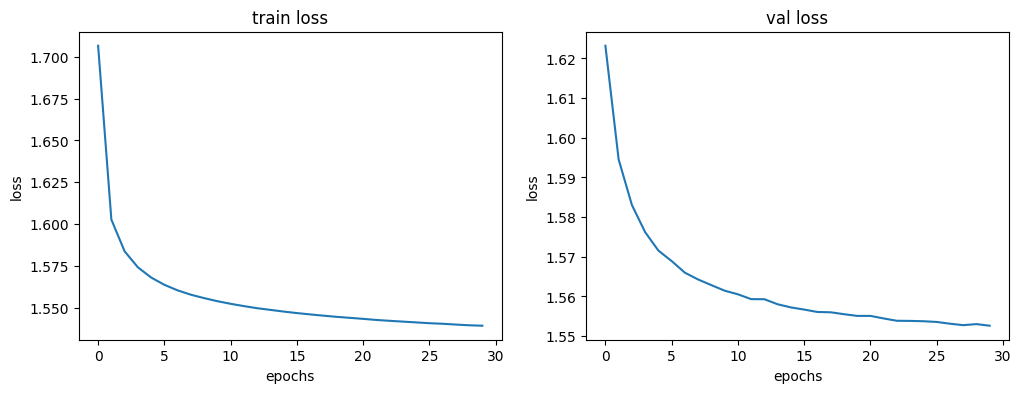

In [ ]:
draw_training_plots(history_epoch)

# Визуализация весов модели после обучения

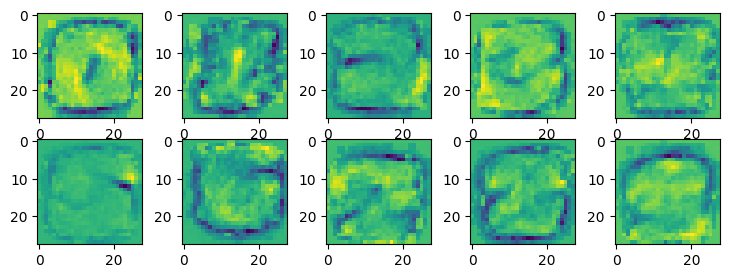

In [ ]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(12, 4)
)

wght = model[0].weight.detach().numpy().reshape(10, 28, 28)

for i in range(5):
    axes[0][i].imshow(wght[i])
    axes[1][i].imshow(wght[5+i])

# Метрики на результатах обучения

выведем y_pred

In [ ]:
preds = model(torch.from_numpy(np.array(test, dtype=np.float32)))
preds = preds.detach().numpy()

In [ ]:
preds = preds.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print(classification_report(test_labels, preds, labels=labels, zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        98
           1       0.99      0.94      0.96       102
           2       0.94      0.97      0.96       105
           3       0.96      0.96      0.96       103
           4       0.96      0.95      0.95        96
           5       0.92      0.90      0.91        90
           6       0.96      0.96      0.96       107
           7       0.97      0.99      0.98       107
           8       0.89      0.90      0.89        94
           9       0.94      0.95      0.94        98

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000
